In [12]:
from genalog.pipeline import AnalogDocumentGeneration
from weasyprint import HTML
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image, ImageDraw as D

from datasets import load_dataset
import fuzzysearch

from typing import List, Tuple, Dict, Union, Optional
import numpy as np
import wandb
import copy
import yaml

In [3]:
def merge_rectangles(rect1: Tuple[float], rect2: Tuple[float], tolerance=5):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2

    if abs(x1 + w1 - x2) <= tolerance or abs(x2 + w2 - x1) <= tolerance:
        # The rectangles are adjacent horizontally
        new_x = min(x1, x2)
        new_y = min(y1, y2)
        new_w = max(x1 + w1, x2 + w2) - new_x
        new_h = max(y1 + h1, y2 + h2) - new_y
        return (new_x, new_y, new_w, new_h)

    elif abs(y1 + h1 - y2) <= tolerance or abs(y2 + h2 - y1) <= tolerance:
        return None  # The rectangles are adjacent vertically
    else:
        # The rectangles are not adjacent
        return None


def merge_close_rectangles(rectangles: List[Tuple[float]], tolerance=10):
    while True:
        merged = False
        for i in range(len(rectangles)):
            for j in range(i+1, len(rectangles)):
                rect1 = rectangles[i]
                rect2 = rectangles[j]
                merged_rect = merge_rectangles(rect1, rect2, tolerance)
                if merged_rect is not None:
                    # Remove the original rectangles and add the merged rectangle
                    rectangles.remove(rect1)
                    rectangles.remove(rect2)
                    rectangles.append(merged_rect)
                    merged = True
                    break
            if merged:
                break
        if not merged:
            break
    return rectangles


def merge_rectangle_line(rectangles: List[Tuple[float]]):
    """
    A line of rectangles is a set of rectangles that are adjacent horizontally
    """
    min_x = min([x for x, y, w, h in rectangles])
    min_y = min([y for x, y, w, h in rectangles])
    max_x = max([x + w for x, y, w, h in rectangles])
    max_y = max([y + h for x, y, w, h in rectangles])
    merged = (min_x, min_y, max_x - min_x, max_y - min_y)
    return merged
    

def find_rectangle_centers(rectangles: List[Tuple[float]]):
    """
    A function to find the center of a list of rectangles
    """
    centers = []
    for x, y, w, h in rectangles:
        centers.append((x + w/2, y + h/2))
    return centers


def find_rectangle_lines(rectangles: List[Tuple[float]], tolerance=10):
    """
    A function to find lines of rectangles
    """
    centers = find_rectangle_centers(rectangles)
    center_to_index = {center: i for i, center in enumerate(centers)}
    lines = []
    while len(centers) > 0:
        line = []
        center = centers.pop(0)
        line.append(center)
        for i in range(len(centers)):
            center2 = centers[i]
            if abs(center[1] - center2[1]) <= tolerance:
                line.append(center2)
        for center in line[1:]:
            centers.remove(center)
        lines.append([rectangles[center_to_index[center]] for center in line])
    return lines


def merge_rectangle_lines(rectangles: List[Tuple[float]], tolerance=10):
    """
    A function to merge lines of rectangles
    """
    lines = find_rectangle_lines(rectangles, tolerance)
    merged_lines = []
    for line in lines:
        merged_lines.append(merge_rectangle_line(line))
    return merged_lines

In [4]:
DEFAULT_COMBINATIONS = {
    "language": ["en_US"],
     "font_family": ["Garamond"],
     "font_size": ["18px"],
     "text_align": ["justify"],
     "hyphenate": [False],
     "width": ["368px"],
     "height": ["368px"],
     "top_margin": ["0px"],
     "right_margin": ["0px"],
     "bottom_margin": ["0px"],
     "left_margin": ["0px"],
}

{'epochs': 100, 'batch_size': 32, 'squad_version': 1, 'html_template': 'pixel_block.html.jinja'}


Found cached dataset squad (/home/knf792/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


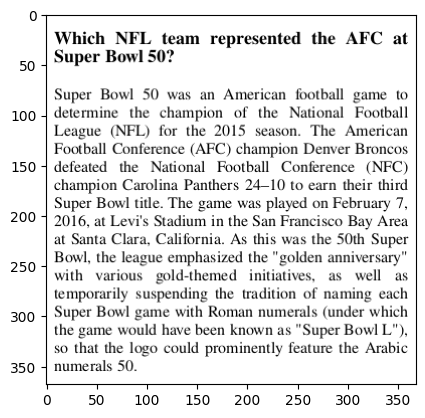

In [26]:
def get_updated_style_config():
    """
    A function to get the updated style config from wandb
    """
    style = copy.deepcopy(DEFAULT_COMBINATIONS)
    for key in style:
        if key in wandb.config:
            style[key] = [wandb.config[key]]
    return style
        

def generate_random_pattern(font: str = "Arial", font_size: int = 16):
    pattern = '<span style=font-weight:bold>{question}</span><br><br><span style=font-size:16px;font-family:%s>{context}</span>' % font
    return pattern


def construct_image_from_squad_instance(instance: Dict,
                                        pattern: str,
                                        style: Dict,
                                        image_resolution: int = 96,
                                        channel: str = 'GRAYSCALE',
                                        template: str = "pixel_block.html.jinja",
                                        template_path: Optional[str] = None) -> np.ndarray:
    """
    A function to construct an image from a SQuAD instance, given a pattern and a style
    :param instance: A SQuAD instance
    :param pattern: A pattern to construct the content of the image
    :param style: A style to construct the image
    :param image_resolution: The resolution of the image
    :param channel: The channel of the image, either 'GRAYSCALE' or 'RGB' or 'RGBA'
    """
    question = instance['question']
    context = instance['context']
    content = pattern.format(question=question, context=context)
    
    doc_generation = AnalogDocumentGeneration(styles=style,
                                              degradations=[],
                                              resolution=image_resolution,
                                              template_path=template_path)
    img_array = doc_generation.generate_img(content, template, target_folder=None, channel=channel)
    return img_array
    

def main():
    wandb.init(config="config.yaml", mode="disabled")
    print(wandb.config)
    
    squad = load_dataset('squad', split='validation') if wandb.config.squad_version == 1 else load_dataset('squad_v2', split='validation')
    style = get_updated_style_config()
    pattern = generate_random_pattern(font="Garamond")
    template = wandb.config.html_template
    image = construct_image_from_squad_instance(squad[0], pattern, style, template=template)
    plt.imshow(image, cmap='gray')

main()

In [24]:
d = pytesseract.image_to_data(img_array, lang='eng', output_type=pytesseract.Output.DICT)

In [30]:
all_text_offest_map = dict()
all_texts = ""
for i, text in enumerate(d['text']):
    if text.strip() != "":
        for j in range(len(text)):
            all_text_offest_map[len(all_texts) + j] = i
        all_texts += text + " "

match = fuzzysearch.find_near_matches(answer, all_texts, max_l_dist=int(len(answer) ** 0.4))
match

[Match(start=515, end=531, dist=2, matched='Laveme & Shirley')]

In [32]:
start_id = all_text_offest_map[match[0].start]
end_id = all_text_offest_map[match[0].end-1]
all_rectangles = []
for i in range(start_id, end_id+1):
    if d["text"][i].strip() != "":
        print(d["text"][i])
        all_rectangles.append((d['left'][i], d['top'][i], d['width'][i], d['height'][i]))


Laveme
&
Shirley,


In [38]:
print(all_rectangles)
merged_rectangles = merge_rectangle_lines(all_rectangles, tolerance=10)
print(merged_rectangles)

[(282, 217, 53, 11), (348, 217, 11, 11), (9, 235, 30, 11)]
[(282, 217, 77, 11), (9, 235, 30, 11)]


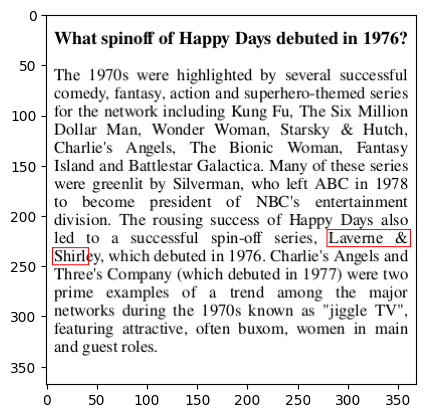

In [39]:
img = Image.fromarray(img_array)
img = img.convert('RGB')
draw=D.Draw(img)
for i in range(len(merged_rectangles)):
    (x, y, w, h) = merged_rectangles[i]
    # add a rectangle to the image
    draw.rectangle(((x-3, y-3), (x + w + 3, y + h + 3)), outline='red')
plt.imshow(img)

In [ ]:
fuzz.